# Model Candidates and Justification

Based on the ACF and PACF analysis after applying seasonal differencing (D=1, s=12), I suggest the following **parsimonious models**, which aim to capture the main dynamics with minimal complexity:

- $SARIMA(1,0,1)(0,1,0)_{12}$ 
- $SARIMA(1,0,1)(0,1,0)_{12}$
- $SARIMA(1,0,1)(0,1,0)_{12}$

However, to evaluate whether the seasonal structure might have been **underestimated**, I will also test more **complex seasonal models** that include additional seasonal AR or MA terms:

- $SARIMA(1,0,1)(1,1,0)_{12}$  
- $SARIMA(1,0,1)(0,1,1)_{12}$ 
- $SARIMA(1,0,1)(1,1,1)_{12}$


In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from utils_residuals import *

## Models fitting

In [11]:
serie_original = pd.read_parquet("../Data/clean_data.parquet")
serie_original = pd.Series(serie_original["value"], name="AverageTemperature")
serie_original.index = pd.DatetimeIndex(serie_original.index)
serie = serie_original.asfreq("MS")
serie = serie.interpolate().round(2)
serie.sample(10)

date
2019-03-01     1.3
2017-03-01     6.1
2022-10-01    11.4
2020-10-01     9.1
2018-08-01    21.9
2021-07-01    23.6
2020-12-01    -0.7
2018-10-01     9.5
2018-05-01    19.7
2023-07-01    22.6
Name: AverageTemperature, dtype: float64

In [12]:
df = serie.to_frame()
df.to_parquet("../Data/processed_series.parquet")

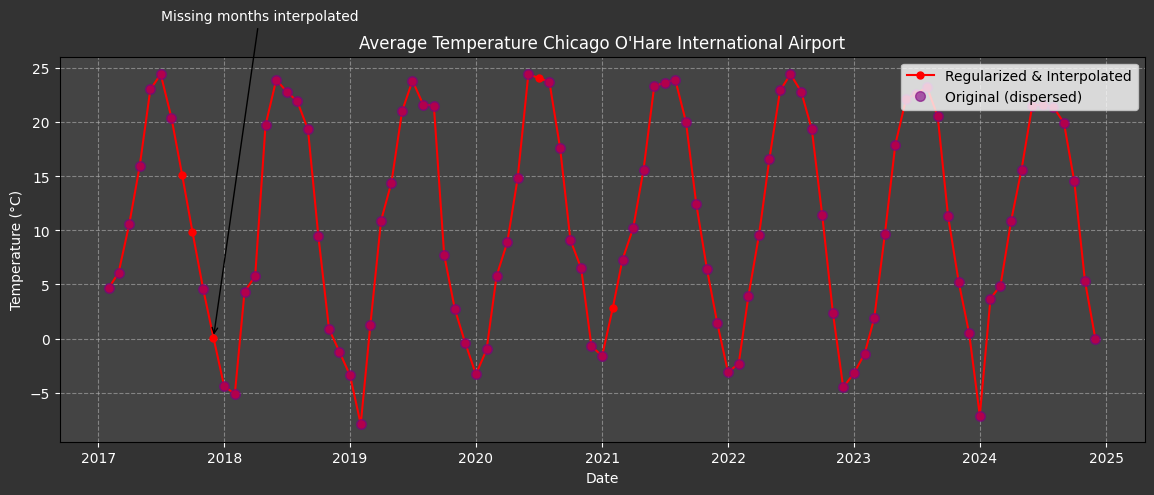

In [13]:
plot_comparative(
    serie=serie,
    serie_original=serie_original,
    path="../Outputs/Figures/temperature_comparison",
    title="Average Temperature Chicago O'Hare International Airport",
    ylabel='Temperature (°C)'
)

In [14]:
models = {
    "SARIMA_(1,0,1)_(0,1,0)": ((1,0,1), (0,1,0,12)),
    "SARIMA_(0,0,1)_(0,1,0)": ((0,0,1), (0,1,0,12)),
    "SARIMA_(1,0,0)_(0,1,0)": ((1,0,0), (0,1,0,12)),
    "SARIMA_(1,0,1)_(1,1,0)": ((1,0,1), (1,1,0,12)),
    "SARIMA_(1,0,1)_(0,1,1)": ((1,0,1), (0,1,1,12)),
    "SARIMA_(1,0,1)_(1,1,1)": ((1,0,1), (1,1,1,12)),
}

results = fit_sarima_models(serie=serie, models=models)

Fitting SARIMA_(1,0,1)_(0,1,0) ...
Fitting SARIMA_(0,0,1)_(0,1,0) ...
Fitting SARIMA_(1,0,0)_(0,1,0) ...
Fitting SARIMA_(1,0,1)_(1,1,0) ...
Fitting SARIMA_(1,0,1)_(0,1,1) ...
Fitting SARIMA_(1,0,1)_(1,1,1) ...


## Residual Analysis (Comparing Models)

In [15]:
residuals = {}
for name in results:
    residuals[name] = results[name].resid

### Residuals close to zero (mean ≈ 0)

In [16]:
residual_mean_test(residuals=residuals)

SARIMA_(1,0,1)_(0,1,0): t-stat = 2.4453, p-value = 0.0163 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(0,0,1)_(0,1,0): t-stat = 2.4866, p-value = 0.0147 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,0)_(0,1,0): t-stat = 2.4820, p-value = 0.0148 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(1,1,0): t-stat = 2.8642, p-value = 0.0052 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(0,1,1): t-stat = 2.7719, p-value = 0.0067 → ❌ Mean ≠ 0 (bad residuals)
SARIMA_(1,0,1)_(1,1,1): t-stat = 2.7760, p-value = 0.0066 → ❌ Mean ≠ 0 (bad residuals)


## Model Rethinking After Residual Diagnostics


Although the ADF test suggested the series was stationary (p-value < 0.05), the initial SARIMA models with `d=0` yielded residuals with a high mean and relatively high variance. This indicated that some trend or structure remained unaccounted for.

As a result, I introduced a non-seasonal differencing (`d=1`). The model `SARIMA(1,1,1)(0,1,0)[12]` produced residuals with a mean closer to zero and significantly reduced variance, indicating a much better fit.

This shows that despite statistical stationarity, the model benefits from differencing to capture hidden trends or reduce structural bias in the residuals.

So I decided to test the same models again, but this time applying a non-seasonal differencing (`d=1`), with the expectation that this adjustment would improve model performance.

The updated list of candidate models is:

- $SARIMA(1,1,1)(0,1,0)_{12}$  
- $SARIMA(1,1,0)(0,1,0)_{12}$  
- $SARIMA(0,1,1)(0,1,0)_{12}$  
- $SARIMA(1,1,1)(1,1,0)_{12}$  
- $SARIMA(1,1,1)(0,1,1)_{12}$  
- $SARIMA(1,1,1)(1,1,1)_{12}$  

## Model Rethinking: Fitting with Non-Seasonal Differencing

In [3]:
serie = pd.read_parquet("../Data/processed_series.parquet")
serie = pd.Series(serie["AverageTemperature"], name="AverageTemperature")
serie.index = pd.DatetimeIndex(serie.index)
serie = serie.asfreq("MS")
freq = pd.infer_freq(serie.index)
print(f"Frecuencia inferida: {freq}")
serie.sample(10)

Frecuencia inferida: MS


date
2017-08-01    20.40
2017-10-01     9.87
2018-08-01    21.90
2024-08-01    21.40
2020-06-01    24.40
2019-05-01    14.40
2017-09-01    15.13
2021-07-01    23.60
2019-11-01     2.70
2019-12-01    -0.40
Name: AverageTemperature, dtype: float64

In [4]:
models = {
    "SARIMA_(1,1,1)_(0,1,0)": ((1,1,1), (0,1,0,12)),
    "SARIMA_(0,1,1)_(0,1,0)": ((0,1,1), (0,1,0,12)),
    "SARIMA_(1,1,0)_(0,1,0)": ((1,1,0), (0,1,0,12)),
    "SARIMA_(1,1,1)_(1,1,0)": ((1,1,1), (1,1,0,12)),
    "SARIMA_(1,1,1)_(0,1,1)": ((1,1,1), (0,1,1,12)),
    "SARIMA_(1,1,1)_(1,1,1)": ((1,1,1), (1,1,1,12)),
}

results = fit_sarima_models(serie=serie, models=models)

Fitting SARIMA_(1,1,1)_(0,1,0) ...
Fitting SARIMA_(0,1,1)_(0,1,0) ...
Fitting SARIMA_(1,1,0)_(0,1,0) ...
Fitting SARIMA_(1,1,1)_(1,1,0) ...
Fitting SARIMA_(1,1,1)_(0,1,1) ...
Fitting SARIMA_(1,1,1)_(1,1,1) ...


## Model Rethinking: Residual Analysis (Comparing Models)

In [6]:
residuals = {}
for name in results:
    residuals[name] = results[name].resid

### Residuals close to zero (mean ≈ 0)

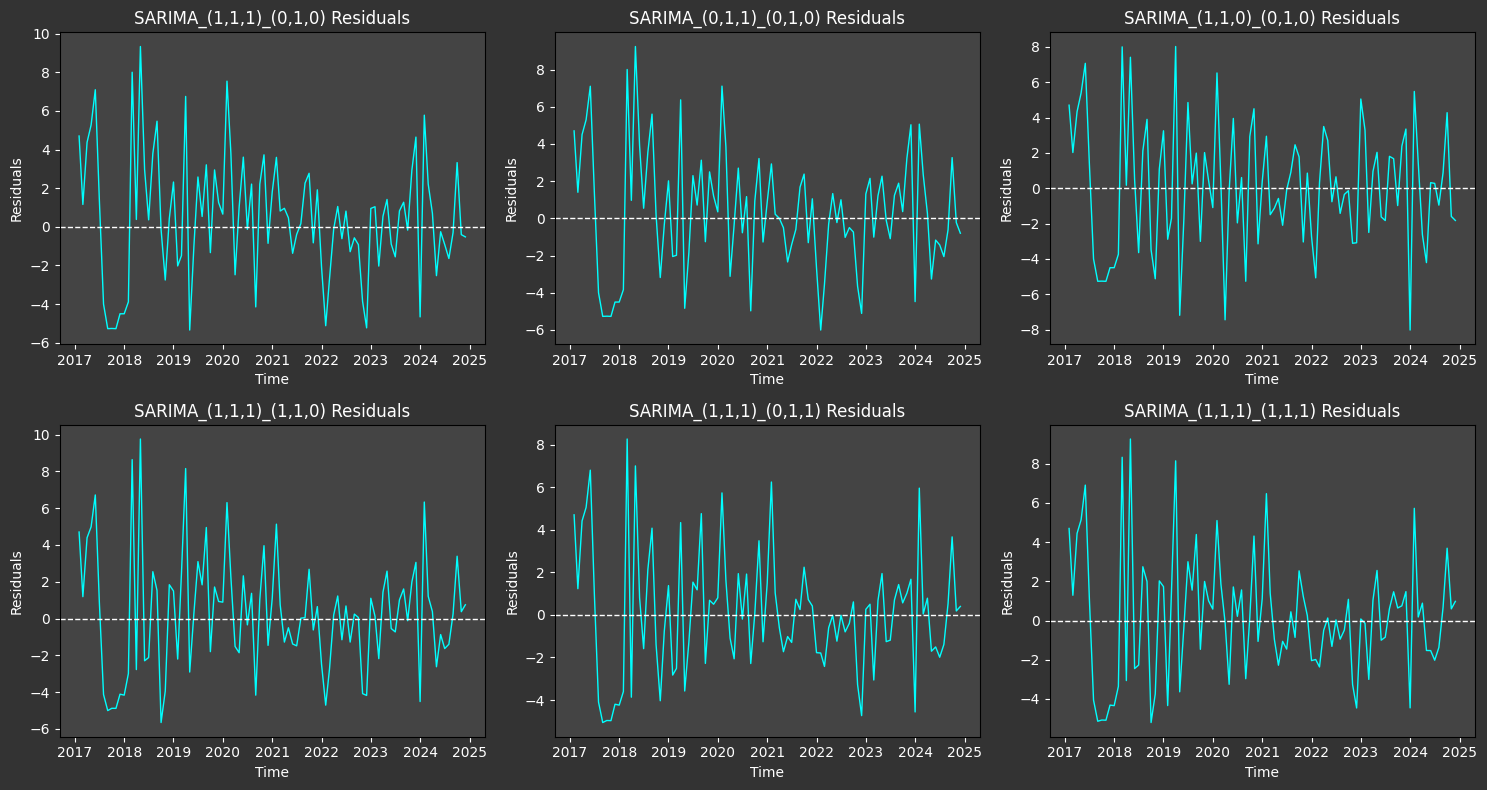

| Model                  |      Mean |     Std |   t-stat |   p-value | Status                       |
|:-----------------------|----------:|--------:|---------:|----------:|:-----------------------------|
| SARIMA_(1,1,1)_(0,1,0) | 0.484532  | 3.20428 | 1.47385  |  0.143863 | ✅ Mean ≈ 0 (good residuals) |
| SARIMA_(0,1,1)_(0,1,0) | 0.31783   | 3.23176 | 0.958558 |  0.34024  | ✅ Mean ≈ 0 (good residuals) |
| SARIMA_(1,1,0)_(0,1,0) | 0.0589415 | 3.53648 | 0.162447 |  0.871302 | ✅ Mean ≈ 0 (good residuals) |
| SARIMA_(1,1,1)_(1,1,0) | 0.259777  | 3.1797  | 0.7963   |  0.427864 | ✅ Mean ≈ 0 (good residuals) |
| SARIMA_(1,1,1)_(0,1,1) | 0.0941884 | 2.89647 | 0.31695  |  0.751984 | ✅ Mean ≈ 0 (good residuals) |
| SARIMA_(1,1,1)_(1,1,1) | 0.188515  | 3.1331  | 0.586454 |  0.558976 | ✅ Mean ≈ 0 (good residuals) |


In [7]:
residual_summary = analyze_residual_mean(residuals, "../Outputs/Figures/residuals_plot.png")
print(residual_summary.to_markdown(index=False))

### Stationarity and Invertibility of the Model

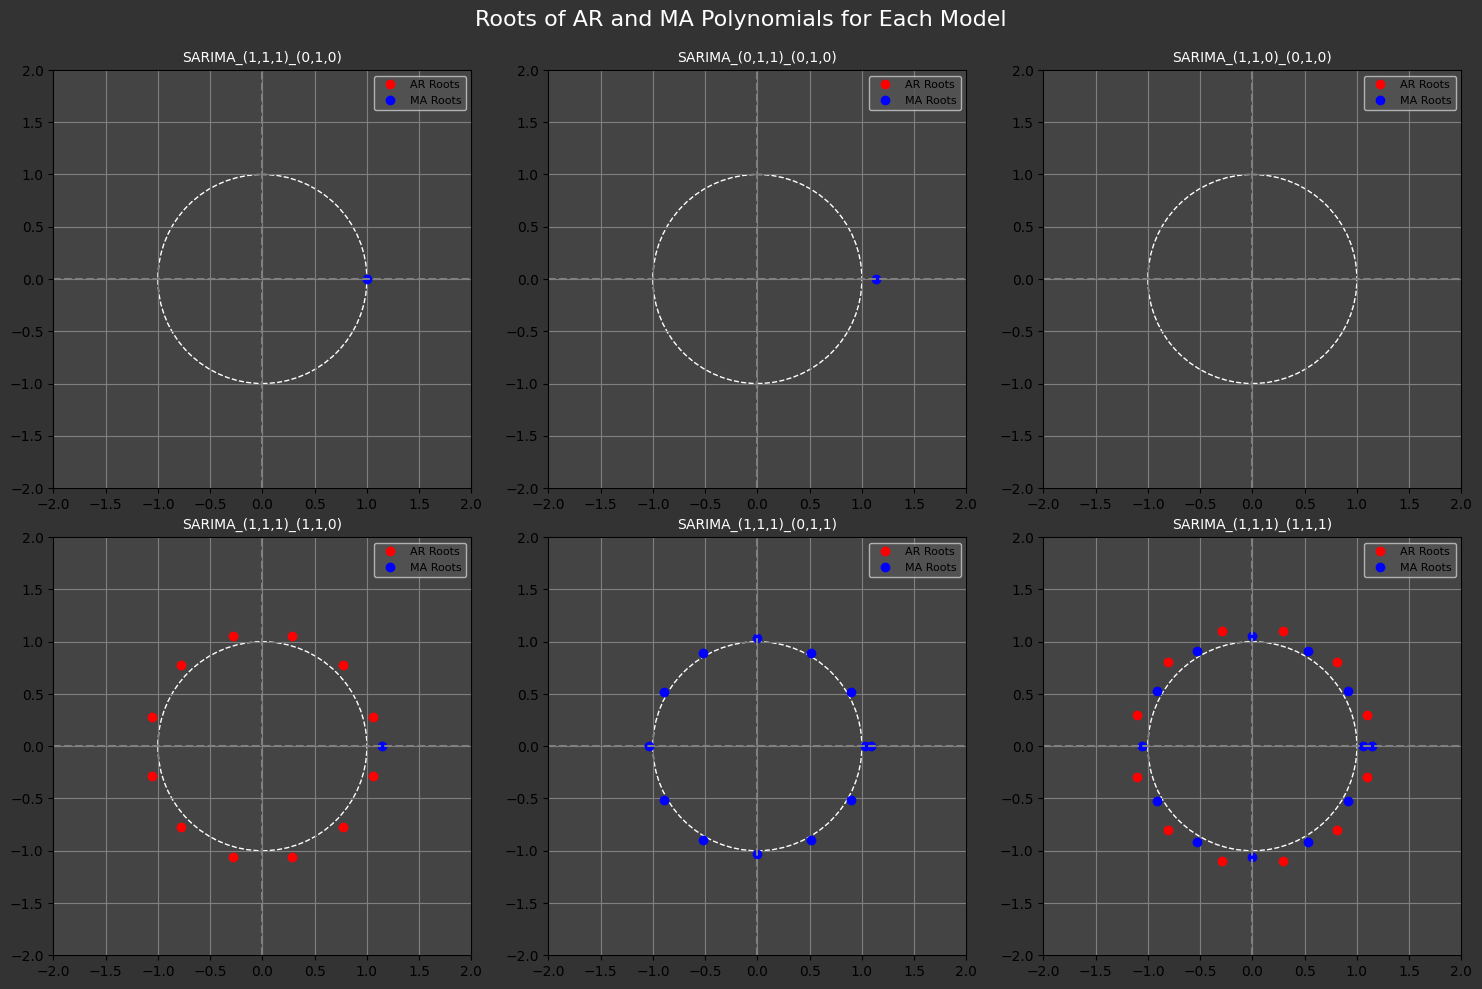

| Model                  | Stationary   | Invertible   |
|:-----------------------|:-------------|:-------------|
| SARIMA_(1,1,1)_(0,1,0) | True         | False        |
| SARIMA_(0,1,1)_(0,1,0) | True         | True         |
| SARIMA_(1,1,0)_(0,1,0) | True         | True         |
| SARIMA_(1,1,1)_(1,1,0) | True         | True         |
| SARIMA_(1,1,1)_(0,1,1) | True         | True         |
| SARIMA_(1,1,1)_(1,1,1) | True         | True         |


In [8]:
stationarity_table = check_stationarity_and_invertibility(results, "../Outputs/Figures/stationarity_invertibility_roots.png")
print(stationarity_table.to_markdown(index=False))

### Homoscedasticity (constant variance)

In [9]:
white_results = white_test(results, verbose=False)
print(white_results.to_markdown(index=False))

| Model                  |   LM Statistic |   LM p-value |   F Statistic |   F p-value | Status                |
|:-----------------------|---------------:|-------------:|--------------:|------------:|:----------------------|
| SARIMA_(1,1,1)_(0,1,0) |       11.2596  |   0.0237966  |       3.02531 |  0.0216852  | ❌ Heteroscedasticity |
| SARIMA_(0,1,1)_(0,1,0) |        9.54086 |   0.0489144  |       2.51195 |  0.0471476  | ❌ Heteroscedasticity |
| SARIMA_(1,1,0)_(0,1,0) |        6.442   |   0.168482   |       1.63672 |  0.17191    | ✅ Homoscedasticity   |
| SARIMA_(1,1,1)_(1,1,0) |        8.08597 |   0.0884793  |       2.09327 |  0.0881957  | ✅ Homoscedasticity   |
| SARIMA_(1,1,1)_(0,1,1) |       13.7841  |   0.00801692 |       3.81874 |  0.00650186 | ❌ Heteroscedasticity |
| SARIMA_(1,1,1)_(1,1,1) |        8.96672 |   0.0619366  |       2.34504 |  0.060586   | ✅ Homoscedasticity   |


### Normality of Residuals

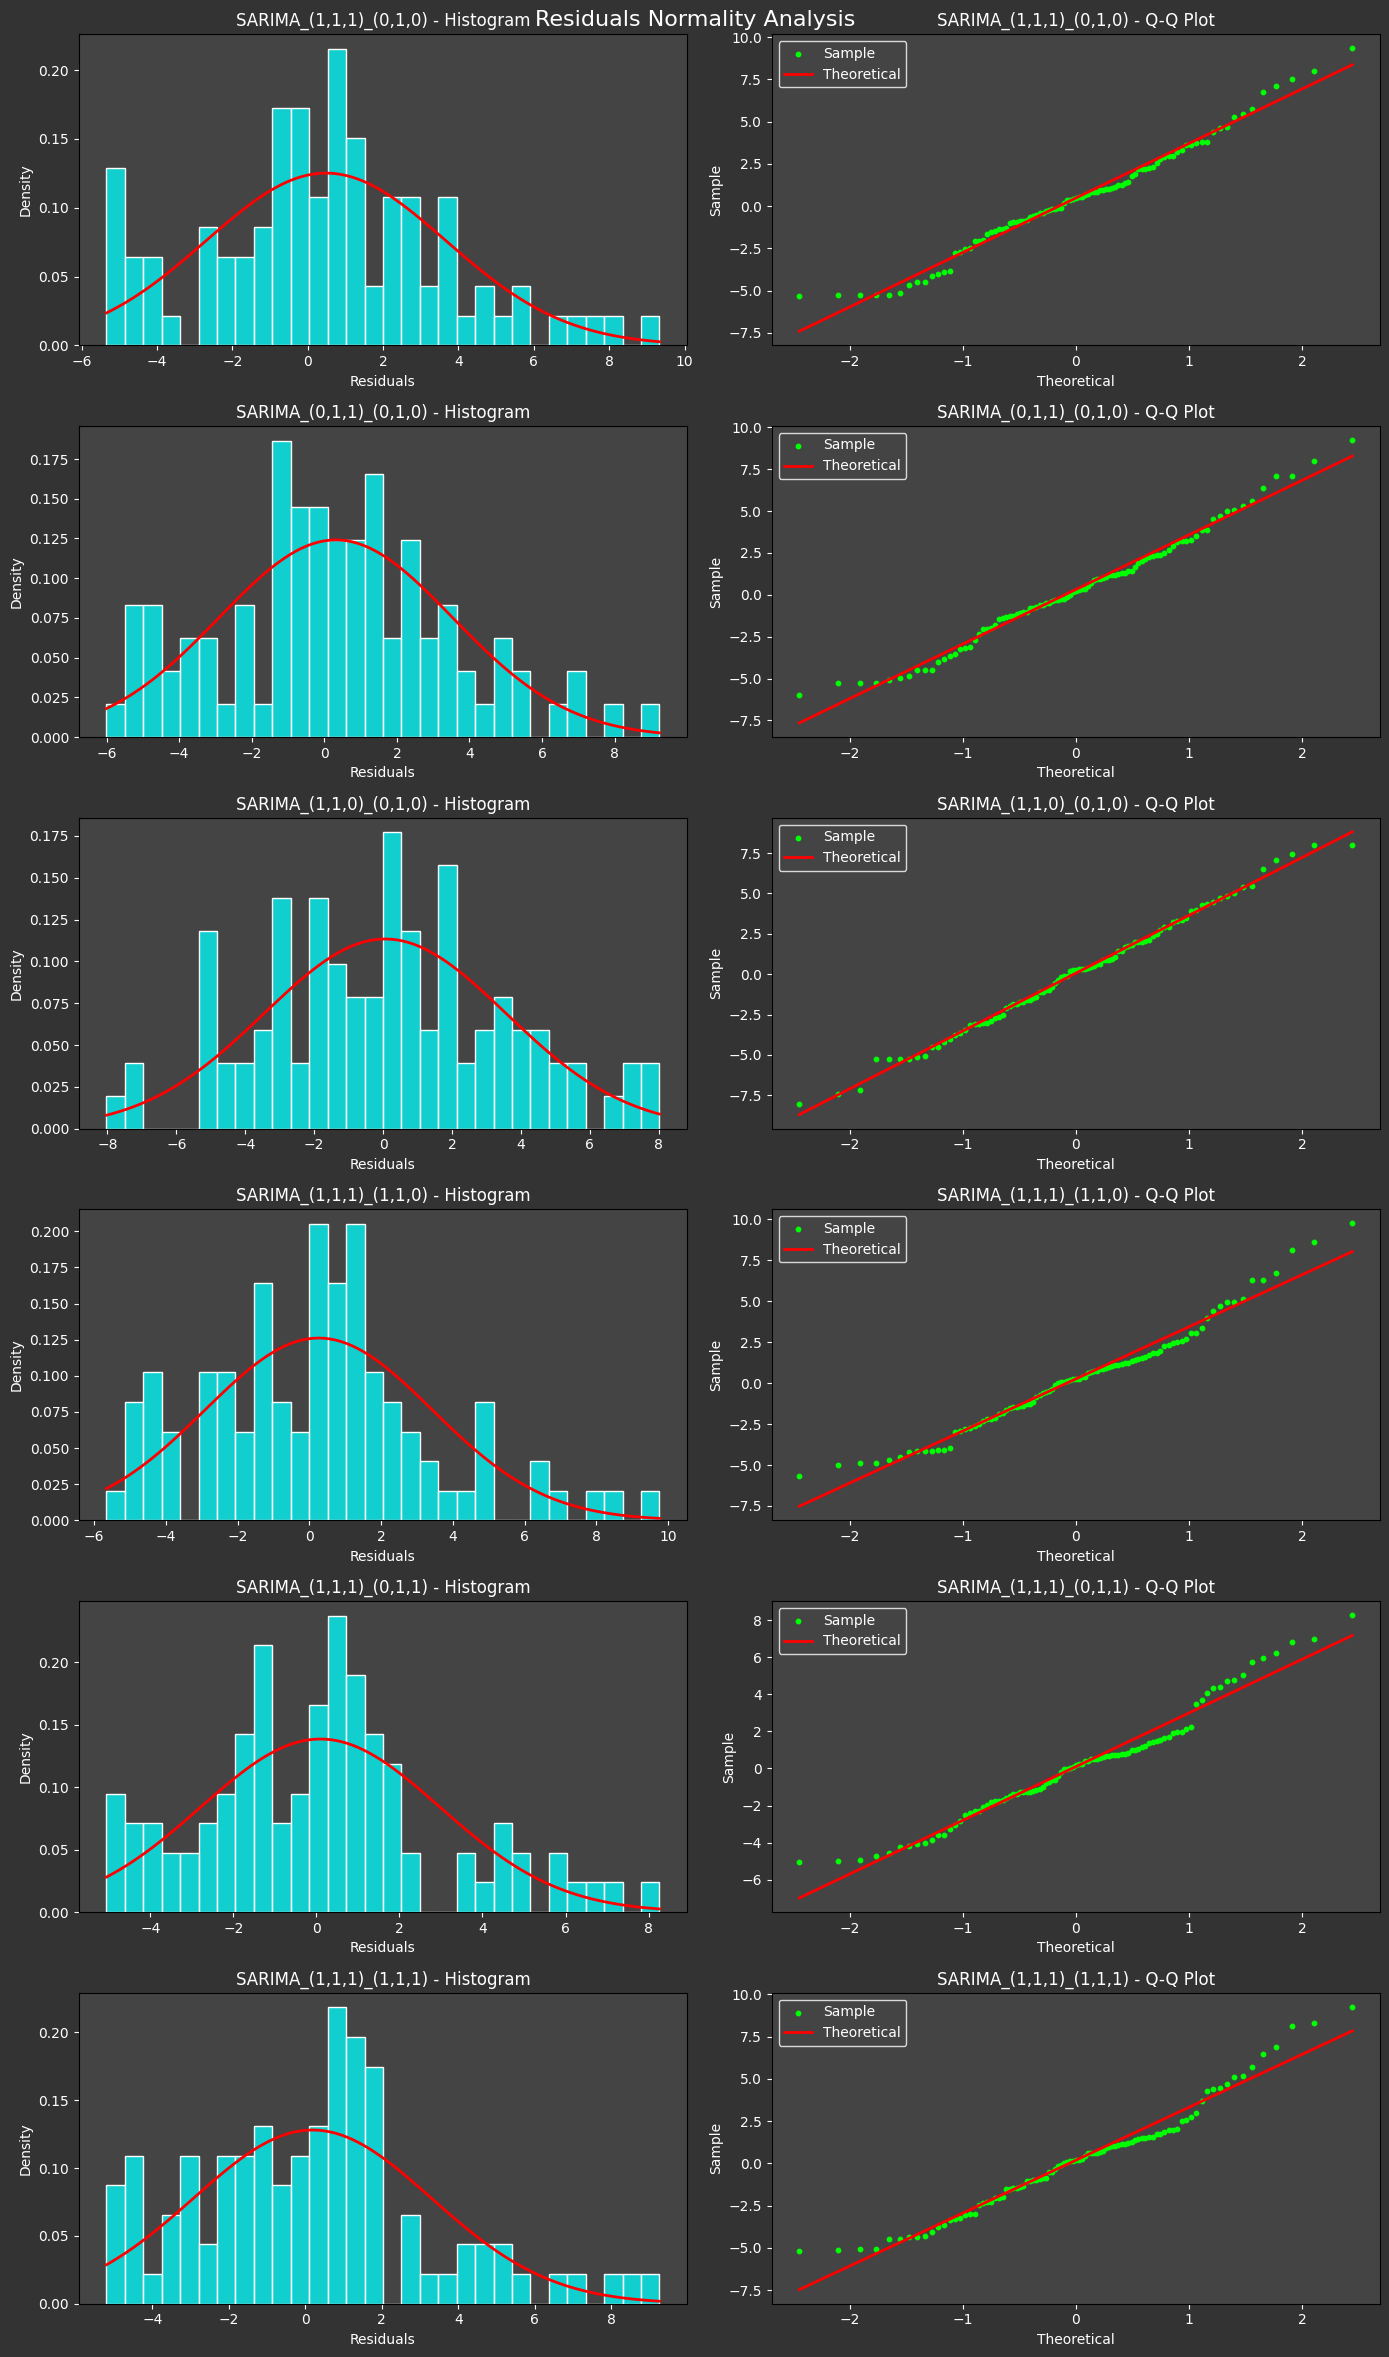

| Model                  |   AD Statistic |   Critical Value (5%) | Status           |
|:-----------------------|---------------:|----------------------:|:-----------------|
| SARIMA_(1,1,1)_(0,1,0) |       0.447269 |                 0.757 | ✅ Normality     |
| SARIMA_(0,1,1)_(0,1,0) |       0.341587 |                 0.757 | ✅ Normality     |
| SARIMA_(1,1,0)_(0,1,0) |       0.143039 |                 0.757 | ✅ Normality     |
| SARIMA_(1,1,1)_(1,1,0) |       0.659733 |                 0.757 | ✅ Normality     |
| SARIMA_(1,1,1)_(0,1,1) |       0.967741 |                 0.757 | ❌ Non-normality |
| SARIMA_(1,1,1)_(1,1,1) |       0.76498  |                 0.757 | ❌ Non-normality |


In [10]:
df_normality = normality_residuals(residuals, path="../Outputs/Figures/residuals_normality.png", verbose=False)
print(df_normality.to_markdown(index=False))


### Non-Autocorrelation of Residuals

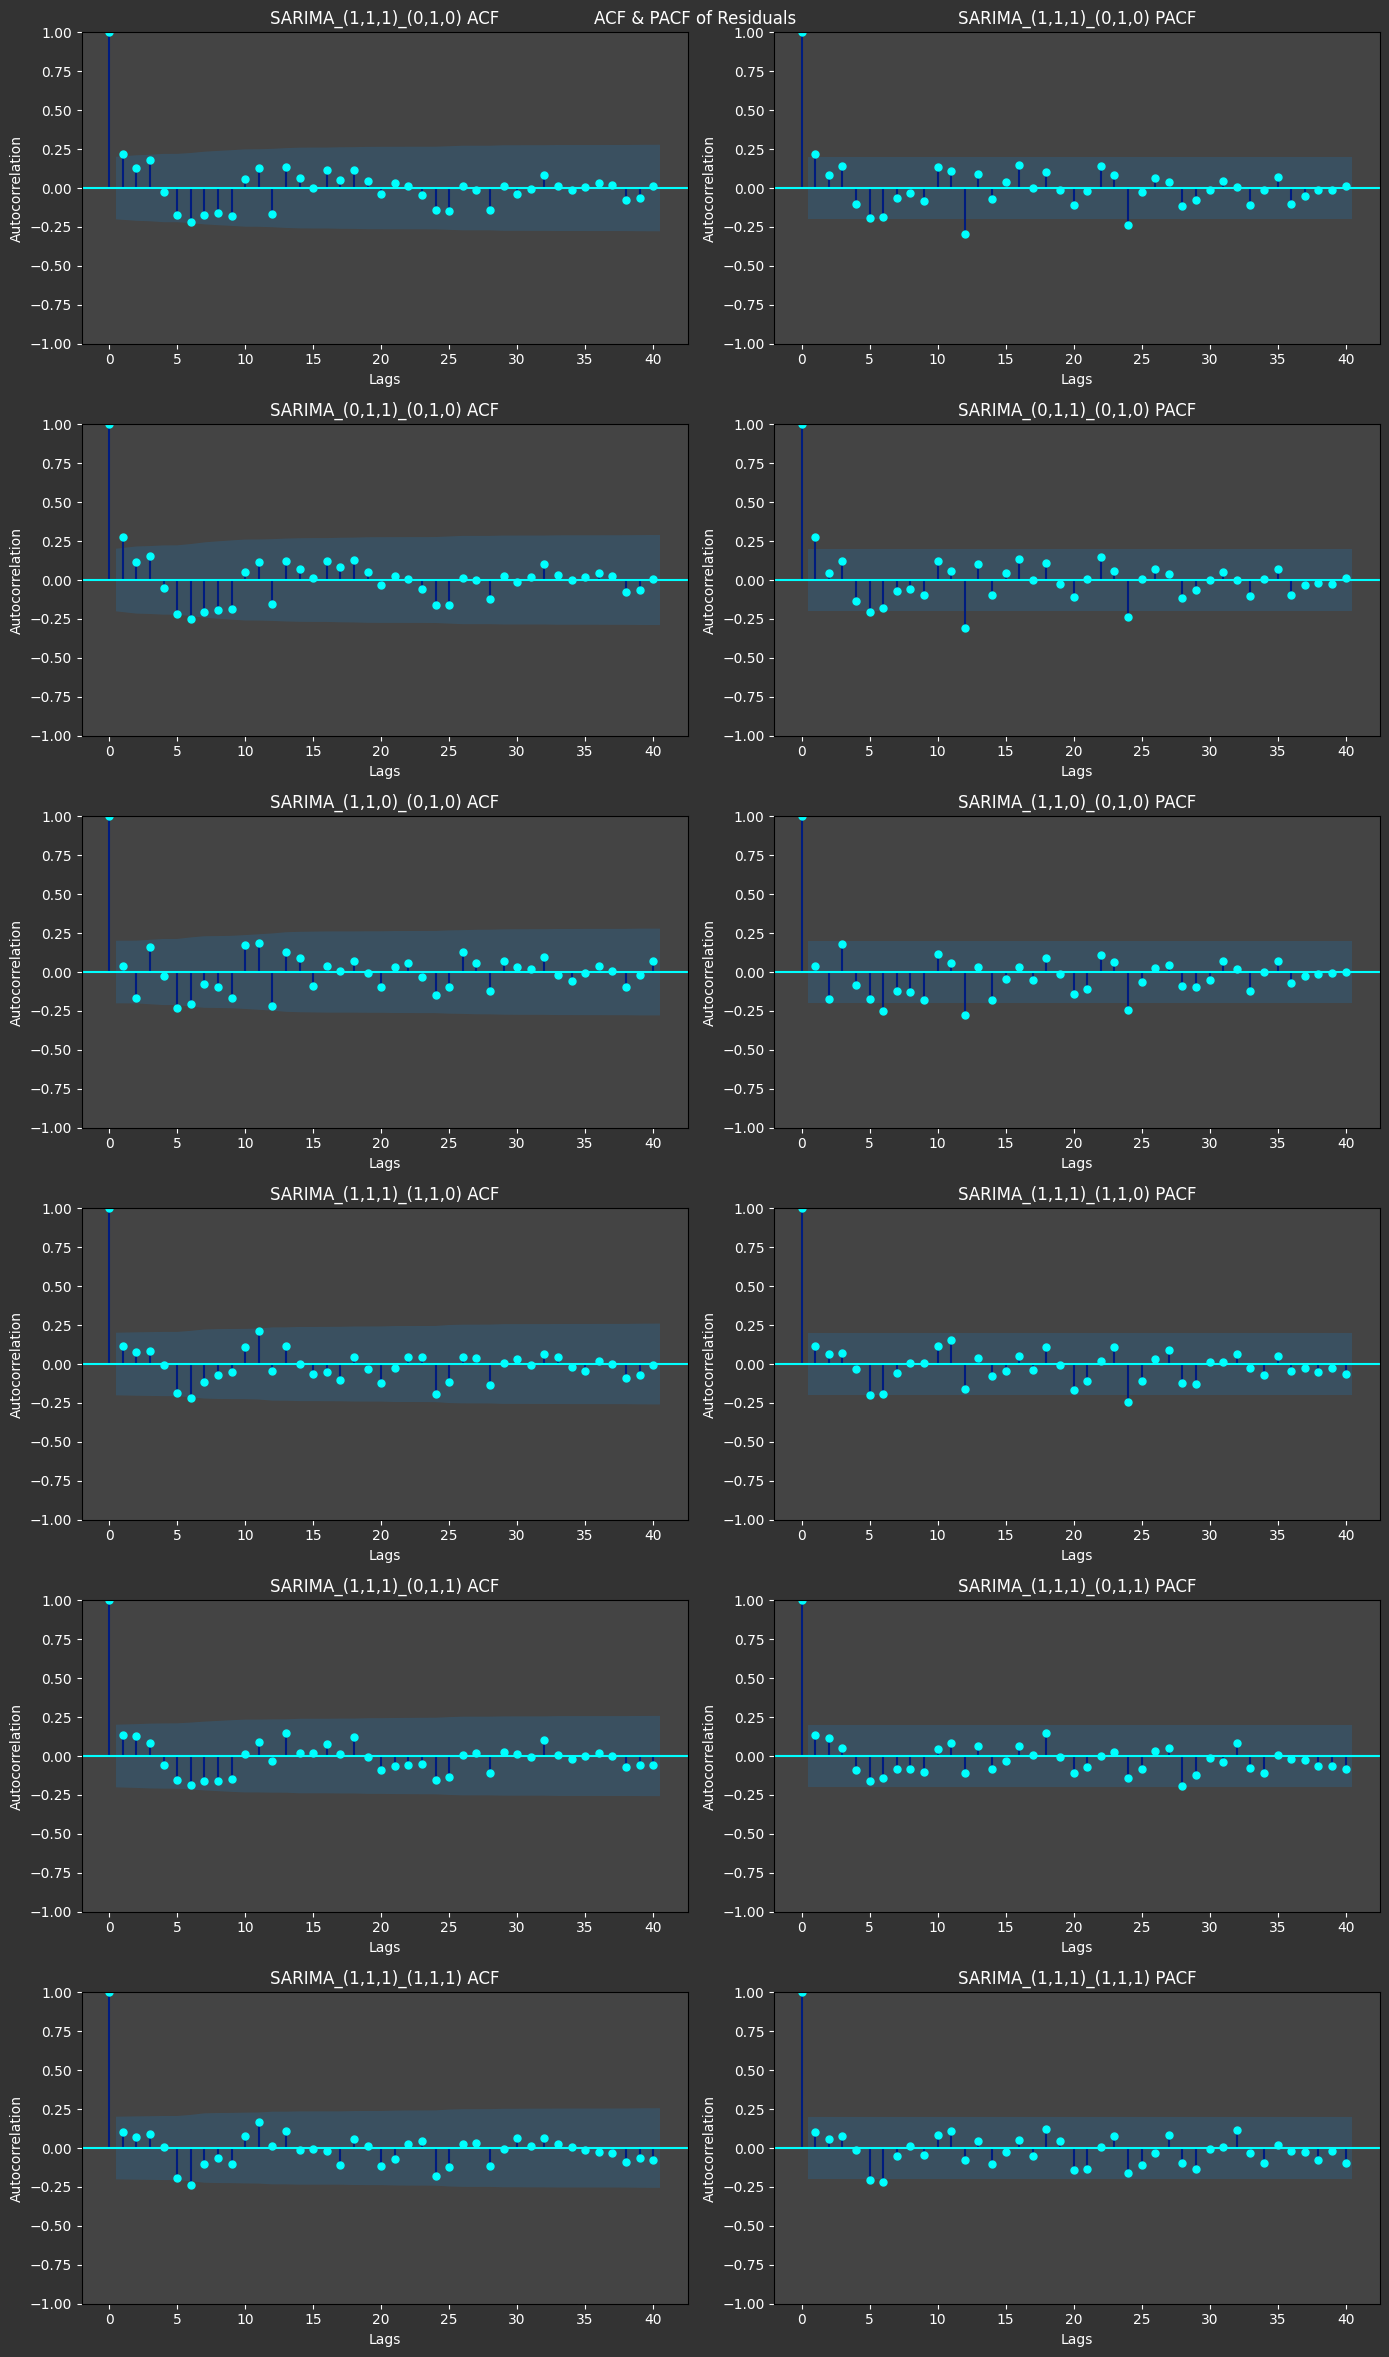

| Model                  |   Ljung-Box p-value | Status                |
|:-----------------------|--------------------:|:----------------------|
| SARIMA_(1,1,1)_(0,1,0) |           0.114037  | ✅ No autocorrelation |
| SARIMA_(0,1,1)_(0,1,0) |           0.0247356 | ❌ Autocorrelation    |
| SARIMA_(1,1,0)_(0,1,0) |           0.0781523 | ✅ No autocorrelation |
| SARIMA_(1,1,1)_(1,1,0) |           0.517598  | ✅ No autocorrelation |
| SARIMA_(1,1,1)_(0,1,1) |           0.588373  | ✅ No autocorrelation |
| SARIMA_(1,1,1)_(1,1,1) |           0.610991  | ✅ No autocorrelation |


In [11]:
autocorr_df = autocorrelation_residuals(
    residuals, 
    path="../Outputs/Figures/residuals_acf_pacf.png", 
    verbose=False, return_df=True
)
print(autocorr_df.to_markdown(index=False))

### Detect Outliers in Residuals

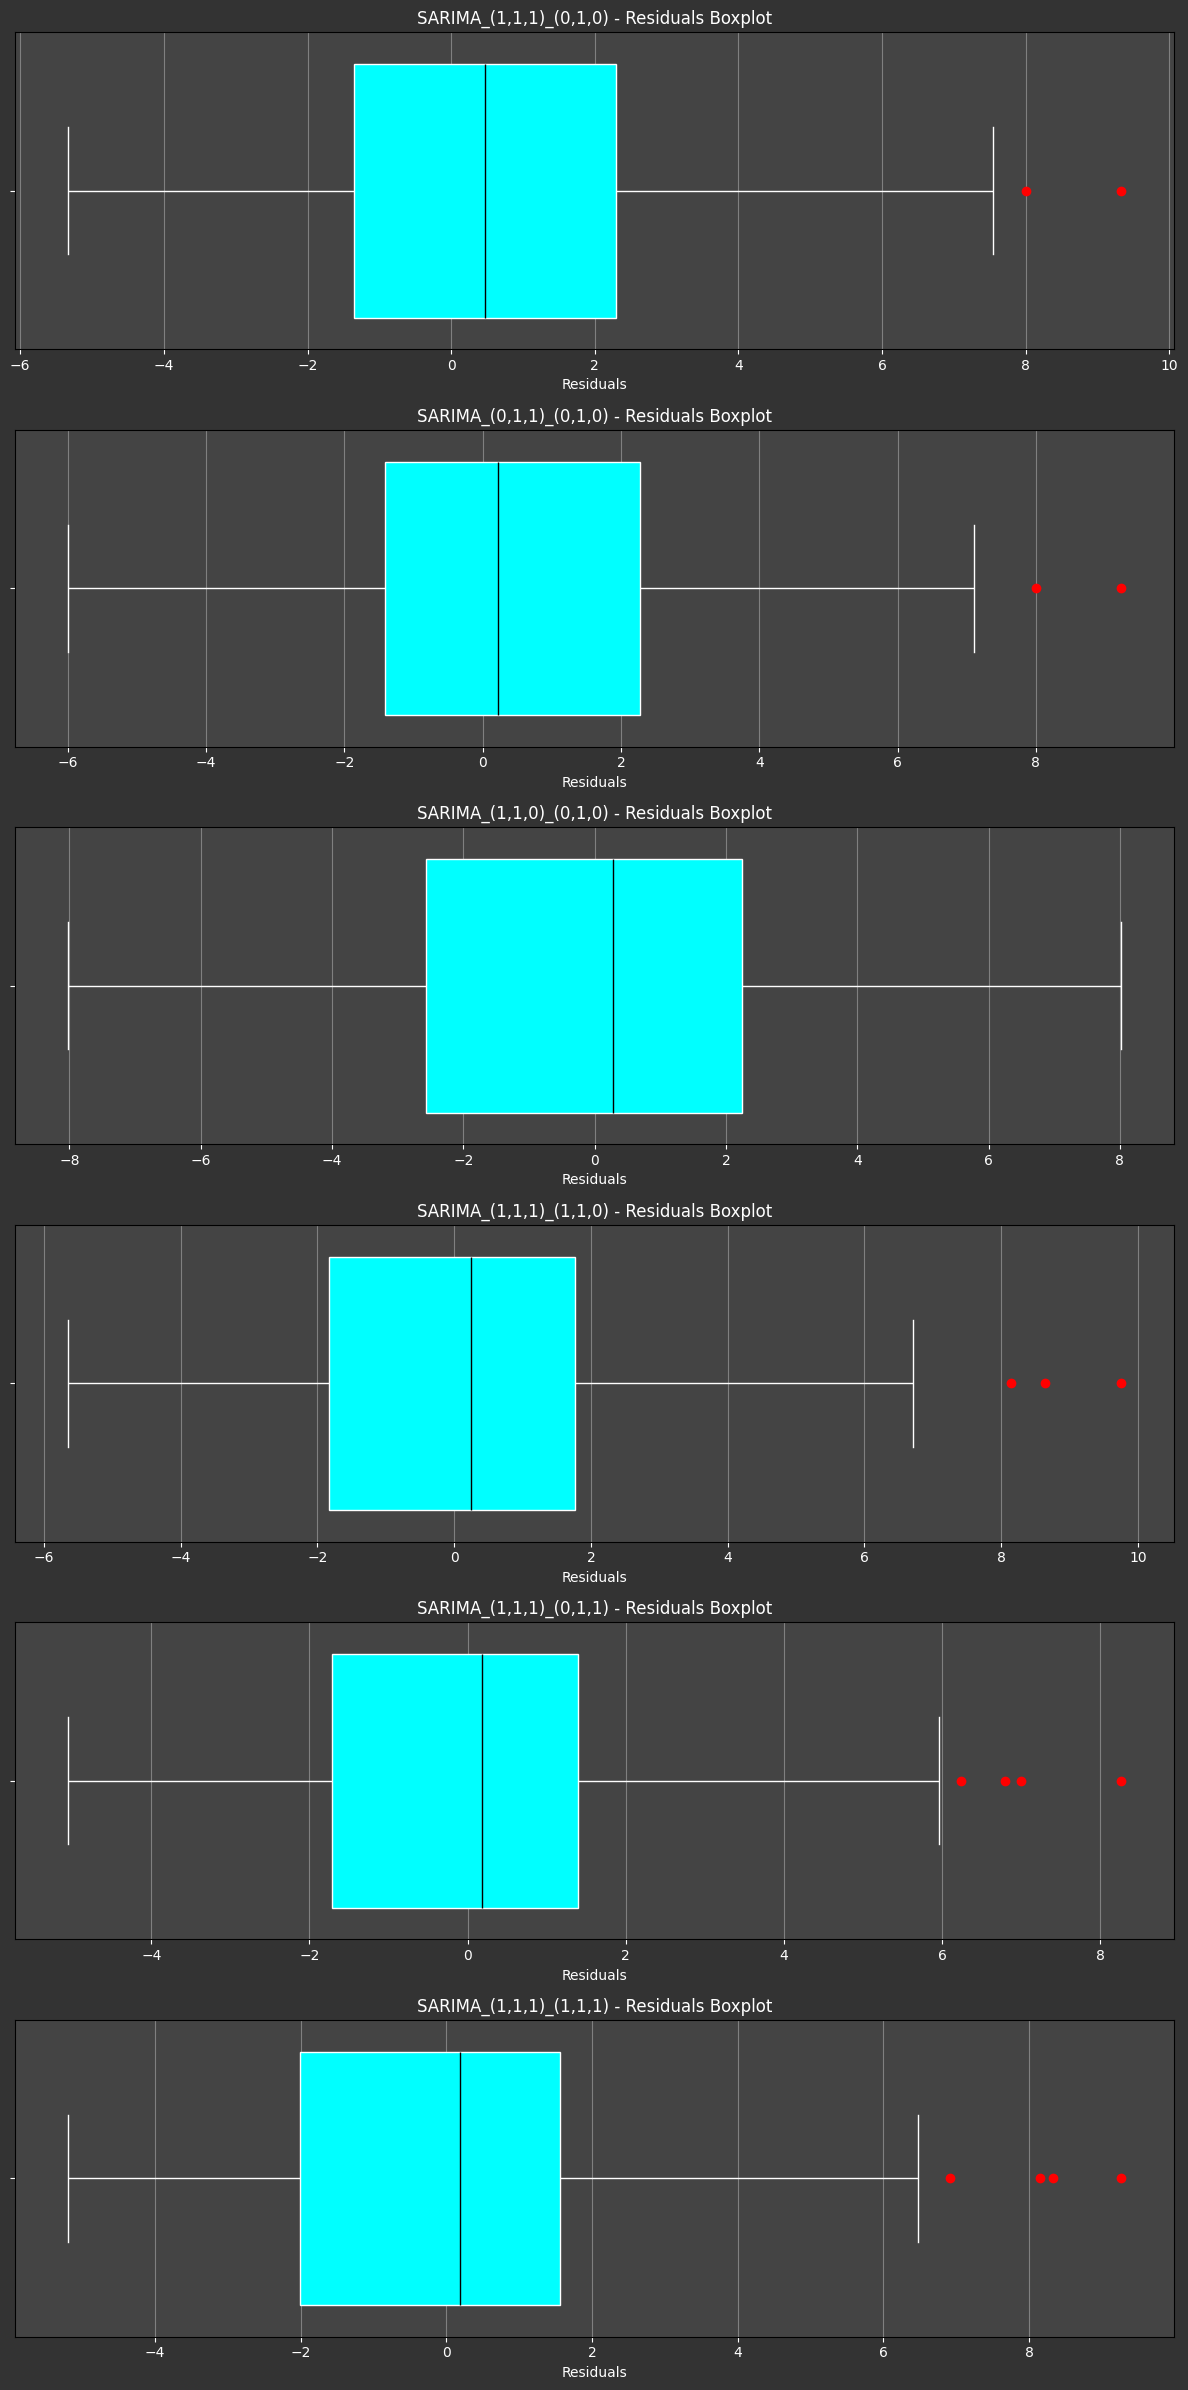

| Model                  | Grubbs   |   Grubbs_Stat |   Grubbs_Crit |   IQR_Outliers |
|:-----------------------|:---------|--------------:|--------------:|---------------:|
| SARIMA_(1,1,1)_(0,1,0) | ✅ None  |         2.761 |         3.366 |              2 |
| SARIMA_(0,1,1)_(0,1,0) | ✅ None  |         2.76  |         3.366 |              2 |
| SARIMA_(1,1,0)_(0,1,0) | ✅ None  |         2.287 |         3.366 |              0 |
| SARIMA_(1,1,1)_(1,1,0) | ✅ None  |         2.986 |         3.366 |              3 |
| SARIMA_(1,1,1)_(0,1,1) | ✅ None  |         2.82  |         3.366 |              4 |
| SARIMA_(1,1,1)_(1,1,1) | ✅ None  |         2.897 |         3.366 |              4 |


In [12]:
outliers_df = detect_outliers_with_plot(
    residuals, 
    save_path="../Outputs/Figures/residuals_boxplot", 
    method="both",
    verbose=False
)
print(outliers_df.to_markdown(index=False))

## Report

In [15]:
image_paths = {
    "residual_plot": "../Outputs/Figures/residuals_plot.png",
    "normality": "../Outputs/Figures/residuals_normality.png",
    "acf_pacf": "../Outputs/Figures/residuals_acf_pacf.png",
    "roots": "../Outputs/Figures/stationarity_invertibility_roots.png",
    "boxplot_outliers": "../Outputs/Figures/residuals_boxplot.png"
}

generate_residual_diagnostics_report(
    df_mean=residual_summary,
    df_normality=df_normality,
    df_ljung=autocorr_df,
    df_white=white_results,
    df_roots=stationarity_table,
    df_outliers=outliers_df,
    image_paths=image_paths,
    output_path="../Reports/residuals_diagnostics_report.md"
)
